In [1]:
#x01_populationStatistics

In [2]:
from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *

In [3]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList


In [4]:
config = get_default_config()
config['n_parents'] = 5
config['n_loci'] = 100
config['pop_size'] = 100
config['max_generations'] = 20
config['total_timesteps'] = 400000
for i in config:
    print(f"{i} : {config[i]}")
env = create_simulation(config)

action_low : 0.05
action_high : 0.95
sparse_reward : False
n_parents : 5
n_chr : 1
n_loci : 100
pop_size : 100
max_generations : 20
h2 : 0.5
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 400000
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gen : 10
end_gen : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : None


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def collect_baselines(env, actions, repetitions=10, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    final_gen_averages = {}
    
    for action in actions:
        final_gen_phenotypes = []
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            for _ in range(cycles):
                env.step(np.array([action]))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
            final_gen_phenotypes.append(cycle_max_phenotype[-1])
        
        final_gen_averages[action] = np.mean(final_gen_phenotypes)
    
    best_action = max(final_gen_averages, key=final_gen_averages.get)
    best_average = final_gen_averages[best_action]
    
    return results, best_action, best_average

def plot_best_run(results, best_action):
    plt.figure(figsize=(10, 6))
    
    max_phenotypes = np.array(results[best_action]['max_phenotype'])
    mean_values = np.mean(max_phenotypes, axis=0)
    std_values = np.std(max_phenotypes, axis=0)
    cycles = range(len(mean_values))
    
    plt.plot(cycles, mean_values, label=f'Action {best_action:.3f}')
    plt.fill_between(cycles, mean_values - std_values, mean_values + std_values, alpha=0.3)
    
    plt.xlabel('Cycle')
    plt.ylabel('Max Phenotype')
    plt.title(f'Max Phenotype over Cycles for Best Action')
    plt.legend()
    plt.grid(True)
    plt.show()



Best action: -0.111
Best average max phenotype in final generation: 7.329


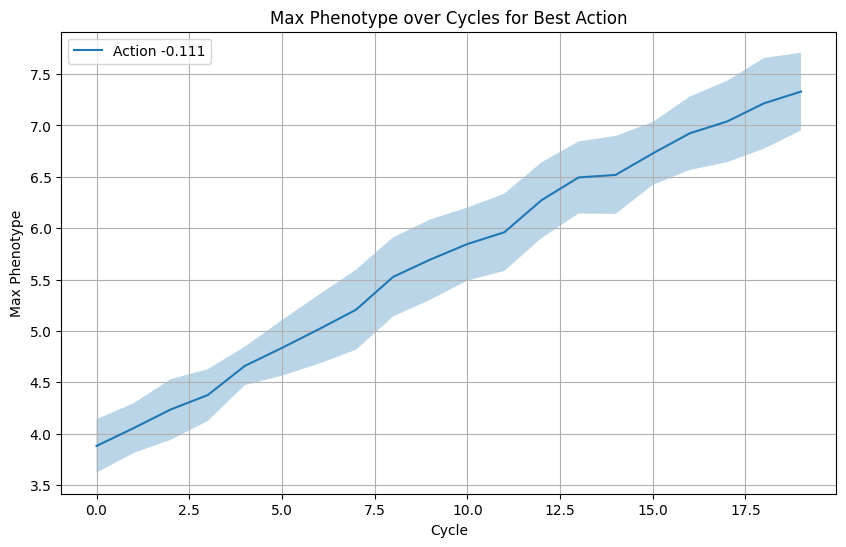

In [7]:
# Usage
actions = np.linspace(-1, 0, 10)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=env.SP.max_generations)

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot only the best run
plot_best_run(results, best_action)


In [8]:
env.reset()

({'population': array([[[[0, 0, 0, ..., 1, 0, 1]],
  
          [[0, 1, 0, ..., 0, 1, 0]]],
  
  
         [[[1, 1, 0, ..., 0, 1, 0]],
  
          [[0, 1, 0, ..., 0, 1, 0]]],
  
  
         [[[0, 1, 0, ..., 0, 1, 0]],
  
          [[0, 1, 0, ..., 0, 1, 0]]],
  
  
         ...,
  
  
         [[[0, 0, 0, ..., 1, 0, 1]],
  
          [[1, 1, 0, ..., 0, 1, 0]]],
  
  
         [[[0, 0, 0, ..., 1, 0, 1]],
  
          [[1, 1, 0, ..., 0, 1, 0]]],
  
  
         [[[0, 1, 0, ..., 0, 1, 0]],
  
          [[0, 0, 0, ..., 1, 0, 1]]]], dtype=int32),
  'generation': array([0.], dtype=float32)},
 {'max_phenotype': 3.4371702671051025,
  'genetic_variance': 1.0,
  'current_generation': 0})

In [ ]:

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=100)
action_callback = ActionTrackingCallback(log_freq=10)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
vec_env = DummyVecEnv([lambda: env])
# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

Using cpu device
Logging to ./ppotb/PPO_19
----------------------------------
| final_generation/   |          |
|    genetic_variance | 0.0212   |
|    max_phenotype    | 5.89     |
| time/               |          |
|    fps              | 403      |
|    iterations       | 1        |
|    time_elapsed     | 5        |
|    total_timesteps  | 2048     |
----------------------------------
-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0283      |
|    max_phenotype        | 5.94        |
| time/                   |             |
|    fps                  | 270         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009240372 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_vari

----------------------------------------
| final_generation/       |            |
|    genetic_variance     | 0.0656     |
|    max_phenotype        | 6.99       |
| time/                   |            |
|    fps                  | 191        |
|    iterations           | 11         |
|    time_elapsed         | 117        |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.01824786 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.35      |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.0003     |
|    loss                 | 6.36       |
|    n_updates            | 100        |
|    policy_gradient_loss | 0.00548    |
|    std                  | 0.932      |
|    value_loss           | 34.2       |
----------------------------------------
------------------------------------------
| final_generation/       |              |
|    genetic

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0349      |
|    max_phenotype        | 6.96        |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 20          |
|    time_elapsed         | 219         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010738272 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.25        |
|    n_updates            | 190         |
|    policy_gradient_loss | 0.00135     |
|    std                  | 0.835       |
|    value_loss           | 22.3        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

------------------------------------------
| final_generation/       |              |
|    genetic_variance     | 0.0317       |
|    max_phenotype        | 7.19         |
| time/                   |              |
|    fps                  | 183          |
|    iterations           | 29           |
|    time_elapsed         | 323          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0057016057 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.33         |
|    n_updates            | 280          |
|    policy_gradient_loss | 0.00383      |
|    std                  | 0.709        |
|    value_loss           | 15.7         |
------------------------------------------
-----------------------------------------
| final_gene

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0124      |
|    max_phenotype        | 6.97        |
| time/                   |             |
|    fps                  | 177         |
|    iterations           | 38          |
|    time_elapsed         | 438         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.008925447 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.962      |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.84        |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.00164     |
|    std                  | 0.628       |
|    value_loss           | 20.6        |
-----------------------------------------
------------------------------------------
| final_generation/       |      

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0104      |
|    max_phenotype        | 7.11        |
| time/                   |             |
|    fps                  | 170         |
|    iterations           | 47          |
|    time_elapsed         | 565         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.009806266 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.829      |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.48        |
|    n_updates            | 460         |
|    policy_gradient_loss | 0.00393     |
|    std                  | 0.55        |
|    value_loss           | 17.4        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.015       |
|    max_phenotype        | 7.32        |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 56          |
|    time_elapsed         | 685         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.012529658 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.68       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.19        |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.00257     |
|    std                  | 0.473       |
|    value_loss           | 18.4        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0167      |
|    max_phenotype        | 7.54        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 65          |
|    time_elapsed         | 805         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.017904758 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.519      |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.23        |
|    n_updates            | 640         |
|    policy_gradient_loss | 0.0047      |
|    std                  | 0.403       |
|    value_loss           | 17.2        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0335      |
|    max_phenotype        | 7.95        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 74          |
|    time_elapsed         | 920         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.036387607 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.441      |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76        |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.012       |
|    std                  | 0.375       |
|    value_loss           | 13.4        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.027       |
|    max_phenotype        | 7.93        |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 83          |
|    time_elapsed         | 1038        |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.019121584 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.349      |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.32        |
|    n_updates            | 820         |
|    policy_gradient_loss | 0.0121      |
|    std                  | 0.34        |
|    value_loss           | 13.4        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0133      |
|    max_phenotype        | 7.75        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 92          |
|    time_elapsed         | 1157        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.026230402 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.66        |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00826     |
|    std                  | 0.311       |
|    value_loss           | 16.1        |
-----------------------------------------
---------------------------------------
| final_generation/       |         

------------------------------------------
| final_generation/       |              |
|    genetic_variance     | 0.0228       |
|    max_phenotype        | 7.82         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 101          |
|    time_elapsed         | 1282         |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0071345316 |
|    clip_fraction        | 0.133        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 4.58         |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00385     |
|    std                  | 0.28         |
|    value_loss           | 12.2         |
------------------------------------------
------------------------------------------
| final_gen

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0196      |
|    max_phenotype        | 7.71        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 110         |
|    time_elapsed         | 1406        |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.014927977 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0373     |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.61        |
|    n_updates            | 1090        |
|    policy_gradient_loss | 0.00131     |
|    std                  | 0.249       |
|    value_loss           | 13.5        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.00873     |
|    max_phenotype        | 7.53        |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 119         |
|    time_elapsed         | 1537        |
|    total_timesteps      | 243712      |
| train/                  |             |
|    approx_kl            | 0.010286048 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0119      |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.61        |
|    n_updates            | 1180        |
|    policy_gradient_loss | 0.0162      |
|    std                  | 0.24        |
|    value_loss           | 17.2        |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.0103      |
|    max_phenotype        | 7.7         |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 128         |
|    time_elapsed         | 1659        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.026544873 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.103       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.45        |
|    n_updates            | 1270        |
|    policy_gradient_loss | 0.0161      |
|    std                  | 0.218       |
|    value_loss           | 17          |
-----------------------------------------
-----------------------------------------
| final_generation/       |       

-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.00621     |
|    max_phenotype        | 7.45        |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 137         |
|    time_elapsed         | 1777        |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.027827075 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.135       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.45        |
|    n_updates            | 1360        |
|    policy_gradient_loss | 0.00693     |
|    std                  | 0.211       |
|    value_loss           | 15.4        |
-----------------------------------------


In [ ]:
config['total_timesteps']